In [3]:
import pandas as pd
import numpy as np

In [4]:
# display options
pd.set_option('display.max_columns', None)

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
from sklearn.linear_model import LinearRegression

To download the dataset, you first need to create a Kaggle account. Then, you can generate an API token as explained here: https://www.kaggle.com/docs/api#authentication and download the data by executing the next cell. Alternatively, you can download and unzip the dataset manually from here https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather.

In [8]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('nicholasjhana/energy-consumption-generation-prices-and-weather', path='../data/hourly_energy_demand_generation_and_weather_SPAIN/', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather


# Electricity price forecasting

In this notebook:

- What will we do?
    - We will learn to clean and pre-process a dataset for electricity prices forecasting, as well as try some feature engineering techniques to improve our model's performance.
    - We will focus on understanding the importance of data preparation.

- What will we NOT do?
    - We will not focus on coding a ML model from scratch or in using very complex models for forecasting.

We will use this Kaggle dataset: https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather/data, which contains 4 years of electrical consumption, generation, pricing, and weather data for Spain.

# Loading the data

pandas library comes in with several functions to read tabular data natively in different formats

For more info: https://pandas.pydata.org/docs/getting_started/intro_tutorials/02_read_write.html

Tabular data is data that can be structured in rows (instances) and columns (features).

Time series (TS) data is not exactly tabular data, since it represents observations collected at different points in time. However, we can present it in a tabular-like format.

Some other types of data are:
 - Text data
 - Image and video data
 - Audio data
 - Geospatial data
 - Graph data

In [9]:
df_demand = pd.read_csv("../data/hourly_energy_demand_generation_and_weather_SPAIN/energy_dataset.csv")
df_weather = pd.read_csv("../data/hourly_energy_demand_generation_and_weather_SPAIN/weather_features.csv")

In [10]:
# we can use the function head() to visualize the first rows of our dataframe
df_demand.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [11]:
# since we are working with time-series data, we want to transform our time column from string type to datetime type
# for convenience in pandas and to set it as the index of our data to identify each datapoint

df_demand.time = pd.to_datetime(df_demand.time, yearfirst=True, infer_datetime_format=True, utc=True).dt.tz_convert(tz='Europe/Brussels')
df_demand.set_index("time", inplace=True)

In [12]:
df_demand.index.min(), df_demand.index.max()

(Timestamp('2015-01-01 00:00:00+0100', tz='Europe/Brussels'),
 Timestamp('2018-12-31 23:00:00+0100', tz='Europe/Brussels'))

# Selecting our data columns

After loading our dataset, one of the first things we should do is inspect our features and try to have an idea of their formats.

Some useful functions for that purpose are info() and describe()

In [13]:
df_demand.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2015-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35045 non-null  float64
 1   generation fossil brown coal/lignite         35046 non-null  float64
 2   generation fossil coal-derived gas           35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation fossil oil shale                  35046 non-null  float64
 7   generation fossil peat                       35046 non-null  float64
 8   generation geothermal                        35046 non-null  float64
 9   generation hydro pumped s

From the previous cell, we can gather a lot of information:
 - Our dataset contains 35064 rows / instances / examples / datapoints
 - Our dataset contains 28 columns (29 if we count the date column)
 - We do not have any categorical feature. All of our features are numerical (float point numbers)
 - A lot of columns contain a few null or NaN values and a couple of columns are completely null

In [14]:
null_columns = ["generation hydro pumped storage aggregated", "forecast wind offshore eday ahead"]

In [15]:
df_demand.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,35045.000000,35045.000000,35046.000000,35045.0,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,475.577343,972.116108,2605.114735,0.0,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,792.406614,400.777536,1835.199745,0.0,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,0.000000,637.000000,1077.250000,0.0,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,68.000000,906.000000,2164.000000,0.0,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,616.000000,1250.000000,3757.000000,0.0,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,4523.000000,2000.000000,9728.000000,0.0,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


From the previous cell, we can learn that, on top of the null columns, we now see that some of the columns have all their values equal to zero.

In [16]:
zero_columns = ["generation fossil coal-derived gas", "generation fossil oil shale", "generation fossil peat", "generation geothermal", "generation marine", "generation wind offshore"]

We also want to get rid of the columns containing forecasts

In [17]:
forecast_columns = ['forecast wind offshore eday ahead', 'total load forecast', 'forecast solar day ahead', 'forecast wind onshore day ahead']

In [18]:
invalid_columns = null_columns + zero_columns + forecast_columns
invalid_columns

['generation hydro pumped storage aggregated',
 'forecast wind offshore eday ahead',
 'generation fossil coal-derived gas',
 'generation fossil oil shale',
 'generation fossil peat',
 'generation geothermal',
 'generation marine',
 'generation wind offshore',
 'forecast wind offshore eday ahead',
 'total load forecast',
 'forecast solar day ahead',
 'forecast wind onshore day ahead']

In [19]:
# we can use a list comprehension, which are very useful in Python to generate a new list of the columns that we want to keep in our dataframe
# https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions

valid_columns = [col for col in df_demand.columns if col not in invalid_columns]
valid_columns

['generation biomass',
 'generation fossil brown coal/lignite',
 'generation fossil gas',
 'generation fossil hard coal',
 'generation fossil oil',
 'generation hydro pumped storage consumption',
 'generation hydro run-of-river and poundage',
 'generation hydro water reservoir',
 'generation nuclear',
 'generation other',
 'generation other renewable',
 'generation solar',
 'generation waste',
 'generation wind onshore',
 'total load actual',
 'price day ahead',
 'price actual']

In [20]:
# we can then use the mask of keep-columns to select those from our dataframe

df_demand = df_demand[valid_columns]

In [21]:
## alternatively, we could also use the drop() function

# df_demand.drop(columns=invalid_columns, inplace=True)

In [22]:
df_demand.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,50.10,65.41
2015-01-01 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,48.10,64.92
2015-01-01 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,47.33,64.48
2015-01-01 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,42.27,59.32
2015-01-01 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,38.41,56.04


And by that, we just defined our list of features and target columns

In [23]:
feature_columns = valid_columns.copy()
feature_columns.remove('price actual')

target_column = 'price actual'

# Imputing missing values

As we saw before, sometimes we will encounter missing values in one or more columns in our data.

In [24]:
# example of a datapoint with a missing value for only one feature
df_demand.iloc[16612, :]

generation biomass                                  NaN
generation fossil brown coal/lignite             900.00
generation fossil gas                           4838.00
generation fossil hard coal                     4547.00
generation fossil oil                            269.00
generation hydro pumped storage consumption     1413.00
generation hydro run-of-river and poundage       795.00
generation hydro water reservoir                 435.00
generation nuclear                              5040.00
generation other                                  60.00
generation other renewable                        85.00
generation solar                                  15.00
generation waste                                 227.00
generation wind onshore                         4598.00
total load actual                              23112.00
price day ahead                                   43.19
price actual                                      49.11
Name: 2016-11-23 04:00:00+01:00, dtype: float64

In [25]:
# example of a datapoint with missing values for almost every feature
df_demand.iloc[30896, :]

generation biomass                               NaN
generation fossil brown coal/lignite             NaN
generation fossil gas                            NaN
generation fossil hard coal                      NaN
generation fossil oil                            NaN
generation hydro pumped storage consumption      NaN
generation hydro run-of-river and poundage       NaN
generation hydro water reservoir                 NaN
generation nuclear                               NaN
generation other                                 NaN
generation other renewable                       NaN
generation solar                                 NaN
generation waste                                 NaN
generation wind onshore                          NaN
total load actual                                NaN
price day ahead                                63.01
price actual                                   69.79
Name: 2018-07-11 09:00:00+02:00, dtype: float64

To find all datapoints with at least one missing value we can create a mask that looks for NaN (Not a Number) values in every row and selects those with at least one in the column axis

In [26]:
mask = df_demand.isnull().any(axis=1)
mask

time
2015-01-01 00:00:00+01:00    False
2015-01-01 01:00:00+01:00    False
2015-01-01 02:00:00+01:00    False
2015-01-01 03:00:00+01:00    False
2015-01-01 04:00:00+01:00    False
                             ...  
2018-12-31 19:00:00+01:00    False
2018-12-31 20:00:00+01:00    False
2018-12-31 21:00:00+01:00    False
2018-12-31 22:00:00+01:00    False
2018-12-31 23:00:00+01:00    False
Length: 35064, dtype: bool

In [27]:
df_demand[mask]

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,
2015-01-05 03:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21182.0,35.20,59.68
2015-01-05 12:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.50,79.14
2015-01-05 13:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.80,73.95
2015-01-05 14:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.50,71.93
2015-01-05 15:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.00,71.50
2015-01-05 16:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.00,71.85
2015-01-05 17:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.60,80.53
2015-01-19 19:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39304.0,70.01,88.95
2015-01-19 20:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39262.0,69.00,87.94


What will happen if we try to fit a regressor with NaN values in our data?

In [28]:
df_demand_copy = df_demand.copy()
y = df_demand_copy.pop(target_column)

reg = LinearRegression()
try:
    reg.fit(df_demand_copy, y)
except Exception as e:
    print(e)

Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


We have different options for dealing with the problem of missing data:
 - Directly dropping rows with missing values.
 - Imputing missing values.
    - Simple imputation.
    - Statistical imputation.
    - kNN imputation.

In [29]:
nan_mask = df_demand.isnull().any(axis=1)

In [30]:
df_demand_copy = df_demand.copy()

# Drop rows with NaN values
df_demand_copy.dropna(inplace=True, how='any')

# Check if the delete was succesful
df_demand_copy[nan_mask]

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,


In [31]:
df_demand_copy = df_demand.copy()

# Simple imputation of missing values with a constant
df_demand_copy.fillna(0, inplace=True)

df_demand_copy[nan_mask].head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,
2015-01-05 03:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21182.0,35.2,59.68
2015-01-05 12:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.5,79.14
2015-01-05 13:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.8,73.95
2015-01-05 14:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.5,71.93
2015-01-05 15:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,71.50


In [32]:
df_demand_copy = df_demand.copy()

# Imputation of missing values with mean feature value
df_demand_copy.fillna(df_demand_copy.mean(), inplace=True)

df_demand_copy[nan_mask].head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,
2015-01-05 03:00:00+01:00,383.51354,448.059208,5622.737488,4256.065742,298.319789,475.577343,972.116108,2605.114735,6263.907039,60.228585,85.639702,1432.665925,269.452133,5464.479769,21182.000000,35.2,59.68
2015-01-05 12:00:00+01:00,383.51354,448.059208,5622.737488,4256.065742,298.319789,475.577343,972.116108,2605.114735,6263.907039,60.228585,85.639702,1432.665925,269.452133,5464.479769,28696.939905,35.5,79.14
2015-01-05 13:00:00+01:00,383.51354,448.059208,5622.737488,4256.065742,298.319789,475.577343,972.116108,2605.114735,6263.907039,60.228585,85.639702,1432.665925,269.452133,5464.479769,28696.939905,36.8,73.95
2015-01-05 14:00:00+01:00,383.51354,448.059208,5622.737488,4256.065742,298.319789,475.577343,972.116108,2605.114735,6263.907039,60.228585,85.639702,1432.665925,269.452133,5464.479769,28696.939905,32.5,71.93
2015-01-05 15:00:00+01:00,383.51354,448.059208,5622.737488,4256.065742,298.319789,475.577343,972.116108,2605.114735,6263.907039,60.228585,85.639702,1432.665925,269.452133,5464.479769,28696.939905,30.0,71.50


In [33]:
df_demand_copy = df_demand.copy()

# Imputation of missing values with median feature value
df_demand_copy.fillna(df_demand_copy.median(), inplace=True)

df_demand_copy[nan_mask].head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,
2015-01-05 03:00:00+01:00,367.0,509.0,4969.0,4474.0,300.0,68.0,906.0,2164.0,6566.0,57.0,88.0,616.0,279.0,4849.0,21182.0,35.2,59.68
2015-01-05 12:00:00+01:00,367.0,509.0,4969.0,4474.0,300.0,68.0,906.0,2164.0,6566.0,57.0,88.0,616.0,279.0,4849.0,28901.0,35.5,79.14
2015-01-05 13:00:00+01:00,367.0,509.0,4969.0,4474.0,300.0,68.0,906.0,2164.0,6566.0,57.0,88.0,616.0,279.0,4849.0,28901.0,36.8,73.95
2015-01-05 14:00:00+01:00,367.0,509.0,4969.0,4474.0,300.0,68.0,906.0,2164.0,6566.0,57.0,88.0,616.0,279.0,4849.0,28901.0,32.5,71.93
2015-01-05 15:00:00+01:00,367.0,509.0,4969.0,4474.0,300.0,68.0,906.0,2164.0,6566.0,57.0,88.0,616.0,279.0,4849.0,28901.0,30.0,71.50


In [34]:
from sklearn.impute import KNNImputer

In [35]:
df_demand_copy = df_demand.copy()

# Imputation of missing values with using k-Nearest Neighbor algorithm.
# This method looks for the k nearest (closest measured by euclidean distance) points to a given point
# and imputes the missing values with the mean values of its k neighbors.
# By default, k = 5

imputer = KNNImputer()
df_demand_copy[feature_columns] = imputer.fit_transform(df_demand_copy[feature_columns])

df_demand_copy[nan_mask].head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,
2015-01-05 03:00:00+01:00,307.2,221.2,4192.2,2158.0,228.8,629.4,1133.2,2216.2,6369.8,43.6,80.2,196.6,292.4,4399.6,21182.0,35.2,59.68
2015-01-05 12:00:00+01:00,411.2,189.2,3947.2,2628.6,256.2,1619.8,1339.0,2649.4,5306.6,51.4,77.2,330.6,230.4,6588.6,26865.2,35.5,79.14
2015-01-05 13:00:00+01:00,372.4,124.8,3827.8,3235.0,275.2,1077.2,934.4,3959.2,6145.4,73.2,82.6,1181.2,234.4,7434.4,26820.2,36.8,73.95
2015-01-05 14:00:00+01:00,436.2,0.0,3616.6,2014.4,287.0,1523.8,1469.6,4374.6,6191.6,73.4,84.6,2997.8,254.4,8920.6,28914.6,32.5,71.93
2015-01-05 15:00:00+01:00,374.6,166.0,3652.6,2863.8,259.4,2485.2,916.6,1891.6,6691.2,64.4,67.8,102.0,229.0,9078.8,25074.6,30.0,71.50


## KNNImputer practical example

In [36]:
knn_imputer_example = pd.DataFrame(data=
                                   {
                                       "A": [2., 6.05, 9.5, 1.2, 4., 5.3, 8.0],
                                       "B": [4.45, 3., 2.22, 2.5, 4., 6.6, 7.5],
                                       "C": [2.0, 4.3, 6.9, 5., 2.5, 3., np.nan]
                                   }
                                  )

knn_imputer_example

,A,B,C
0,2.00,4.45,2.0
1,6.05,3.00,4.3
2,9.50,2.22,6.9
3,1.20,2.50,5.0
4,4.00,4.00,2.5
5,5.30,6.60,3.0
6,8.00,7.50,NaN


In [37]:
dists = []
missing_C_point = np.array([8., 7.5])

for i, sample in knn_imputer_example.iterrows():
    if i != 6:
        a, b, _ = sample
        dist = np.linalg.norm(np.array([a,b]) - missing_C_point)
        dists.append(dist)
        print(f"Euclidean distance between point {i} and point 6: {dist}")

Euclidean distance between point 0 and point 6: 6.730713186579859
Euclidean distance between point 1 and point 6: 4.904334817281545
Euclidean distance between point 2 and point 6: 5.488934322798916
Euclidean distance between point 3 and point 6: 8.440379138403676
Euclidean distance between point 4 and point 6: 5.315072906367325
Euclidean distance between point 5 and point 6: 2.8460498941515415


In [38]:
# we take the 3 closest neighbors
neighbors = np.argsort(dists)[:3]
neighbors

array([5, 1, 4], dtype=int64)

In [39]:
neighbors_arr = knn_imputer_example.values[neighbors]
neighbors_arr

array([[5.3 , 6.6 , 3.  ],
       [6.05, 3.  , 4.3 ],
       [4.  , 4.  , 2.5 ]])

In [40]:
# mean value of feature C
neighbors_arr[:, 2].mean()

3.266666666666667

In [41]:
# check that our calculation is correct

imputer = KNNImputer(n_neighbors=3)
imputer.fit_transform(knn_imputer_example)

array([[2.        , 4.45      , 2.        ],
       [6.05      , 3.        , 4.3       ],
       [9.5       , 2.22      , 6.9       ],
       [1.2       , 2.5       , 5.        ],
       [4.        , 4.        , 2.5       ],
       [5.3       , 6.6       , 3.        ],
       [8.        , 7.5       , 3.26666667]])

## Even more data imputation...

Extensive guide on Data Imputation for Time Series Data:

https://medium.com/@aaabulkhair/data-imputation-demystified-time-series-data-69bc9c798cb7

# Visualization

Visualization is a great tool to further understand and contextualize our data.

It is very useful for:
 - Finding correlations between features.
 - Detect outliers.
 - Analyse the data distributions.

However, as our data grows either in features or number of points, it can get very tricky and unconvenient to plot.

With time series data, it can be useful to plot our data for specific time periods (i.e., a given week, month or year) that we want to study.

In [42]:
df_demand_copy = df_demand.copy()
df_demand_copy.dropna(inplace=True, how='any')

In [43]:
price = df_demand_copy['price actual']

## Visualization of the evolution of the electricity price over time

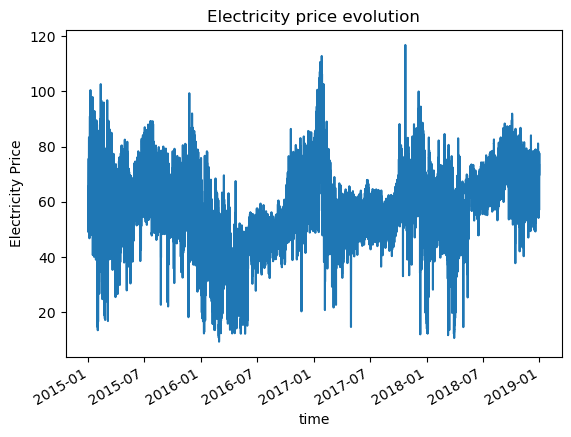

In [44]:
price.plot(ylabel='Electricity Price', title='Electricity price evolution')
plt.show()

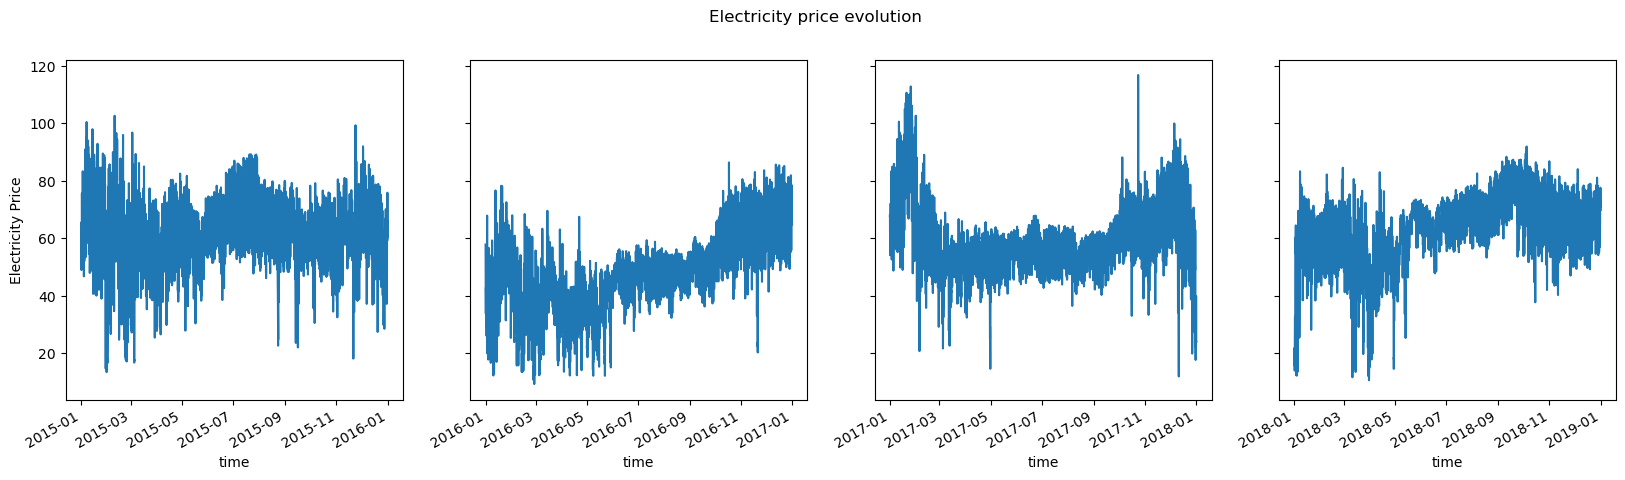

In [45]:
fig, ax = plt.subplots(1, 4, figsize=(20,5), sharey=True)

yr = list(df_demand_copy.index.year.unique())
yr_pairs = [(str(yr[i]), str(yr[i])) for i in range(0, len(yr))]
for i, pair in enumerate(yr_pairs):
    price[pair[0]:pair[1]].plot(ax=ax[i], ylabel='Electricity Price')

fig.suptitle('Electricity price evolution')

plt.show()

## Visualization of (Onshore) Wind generation in March 2017

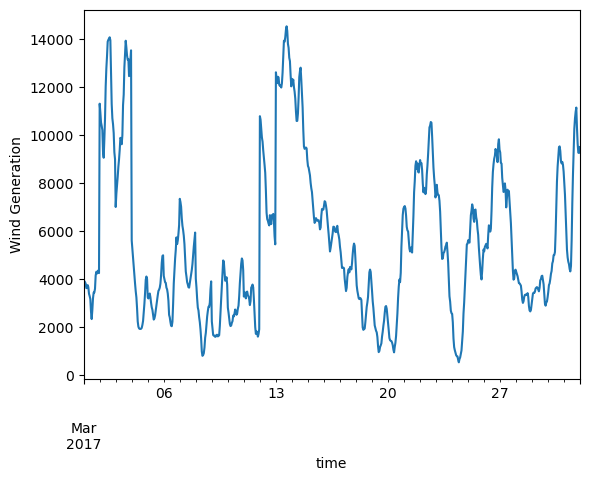

In [46]:
df_demand_copy['2017-03':'2017-03']['generation wind onshore'].plot(ylabel='Wind Generation')
plt.show()

## Visualization of Solar generation on the week 4th-10th June 2018

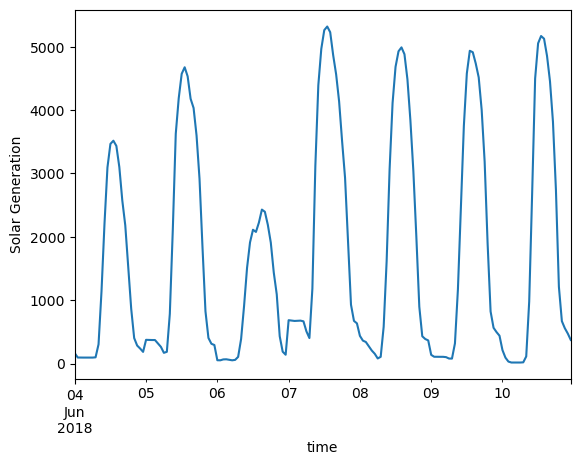

In [47]:
df_demand_copy['2018-06-04':'2018-06-10']['generation solar'].plot(ylabel='Solar Generation')
plt.show()

## Visualization of Demand curve on 15th December 2016

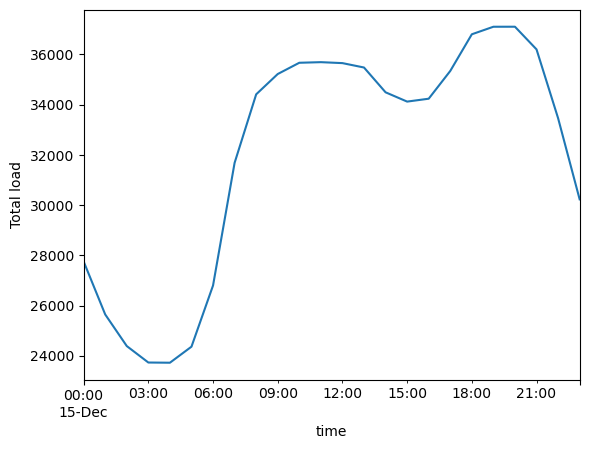

In [48]:
df_demand_copy['2016-12-15':'2016-12-15']['total load actual'].plot(ylabel='Total load')
plt.show()

## Visualizing feature correlation

 - Correlation can be positive (one variable increases as the other one does too) or negative (one variable decreases as the other increases)
 - Correlation ranges from -1 to 1
 - -1 represents perfect negative correlation between two variables
 - +1 represents perfect positive correlation between two variables
 - 0 represents absence of correlation between two variables

https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

In [49]:
corr = df_demand_copy.corr()
corr

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
generation biomass,1.000000,0.229584,-0.021205,0.433096,0.458497,-0.044827,-0.285789,-0.034090,-0.023248,0.658609,-0.563454,-0.004998,-0.348226,-0.069006,0.083211,0.108858,0.142795
generation fossil brown coal/lignite,0.229584,1.000000,0.500143,0.768910,0.314725,-0.323919,-0.525196,-0.229394,-0.008847,0.097370,0.104036,0.040504,0.282639,-0.434507,0.280523,0.568152,0.364205
generation fossil gas,-0.021205,0.500143,1.000000,0.542153,0.310703,-0.420612,-0.271259,0.060425,-0.112099,-0.065886,0.336118,0.074904,0.276181,-0.397278,0.548931,0.640892,0.461914
generation fossil hard coal,0.433096,0.768910,0.542153,1.000000,0.440370,-0.406093,-0.498590,-0.158124,-0.025103,0.264410,-0.020180,0.046070,0.170171,-0.442063,0.396631,0.671672,0.466703
generation fossil oil,0.458497,0.314725,0.310703,0.440370,1.000000,-0.331404,-0.107618,0.160218,0.013162,0.374703,-0.117446,0.099878,-0.177809,-0.052254,0.497069,0.293067,0.285351
generation hydro pumped storage consumption,-0.044827,-0.323919,-0.420612,-0.406093,-0.331404,1.000000,0.053094,-0.234354,0.013085,0.021294,-0.268084,-0.214660,-0.188770,0.389002,-0.562786,-0.600355,-0.427033
generation hydro run-of-river and poundage,-0.285789,-0.525196,-0.271259,-0.498590,-0.107618,0.053094,1.000000,0.652611,-0.125638,-0.127770,0.053087,0.039475,-0.286884,0.223136,0.118587,-0.294712,-0.136756
generation hydro water reservoir,-0.034090,-0.229394,0.060425,-0.158124,0.160218,-0.234354,0.652611,1.000000,-0.050872,0.065159,-0.065875,0.091815,-0.288605,-0.019223,0.479485,-0.017834,0.072203
generation nuclear,-0.023248,-0.008847,-0.112099,-0.025103,0.013162,0.013085,-0.125638,-0.050872,1.000000,0.040401,-0.065093,0.003894,0.084937,0.048812,0.085598,-0.043961,-0.051825
generation other,0.658609,0.097370,-0.065886,0.264410,0.374703,0.021294,-0.127770,0.065159,0.040401,1.000000,-0.445721,-0.016681,-0.362433,0.047060,0.100666,0.043945,0.099757


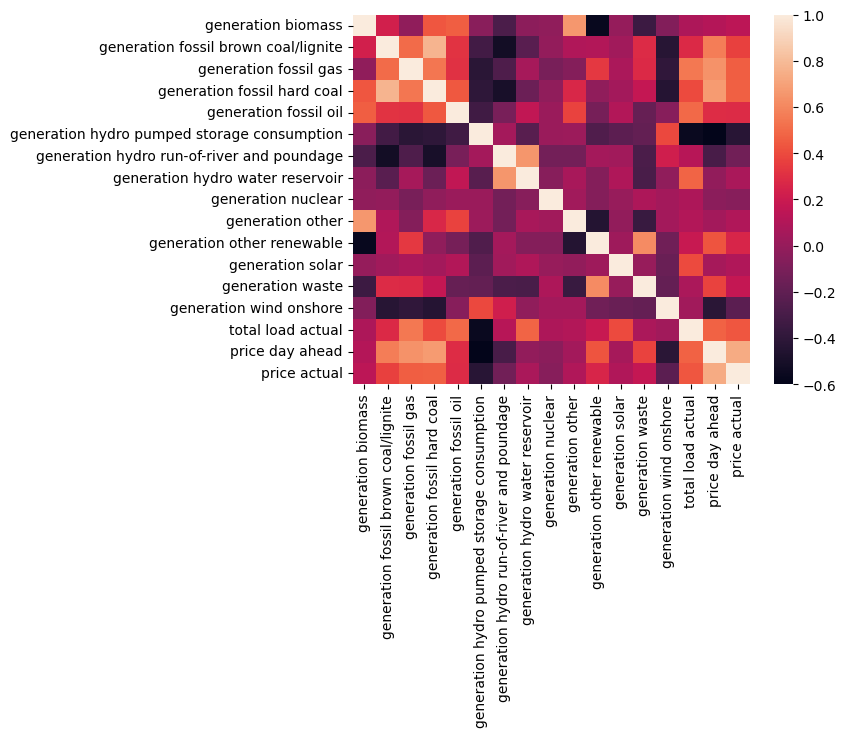

In [50]:
sns.heatmap(corr)
plt.show()

Now let's visualize highly correlated features. We will assume two variables are highly correlated if their correlation is smaller than -0.6 or larger than 0.6

In [51]:
upper_triangle = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
correlation_df = upper_triangle.stack().reset_index()
correlation_df.columns = ['Feature1', 'Feature2', 'Correlation']
correlation_df

,Feature1,Feature2,Correlation
0,generation biomass,generation fossil brown coal/lignite,0.229584
1,generation biomass,generation fossil gas,-0.021205
2,generation biomass,generation fossil hard coal,0.433096
3,generation biomass,generation fossil oil,0.458497
4,generation biomass,generation hydro pumped storage consumption,-0.044827
...,...,...,...
131,generation wind onshore,price day ahead,-0.424812
132,generation wind onshore,price actual,-0.221762
133,total load actual,price day ahead,0.473776
134,total load actual,price actual,0.435872


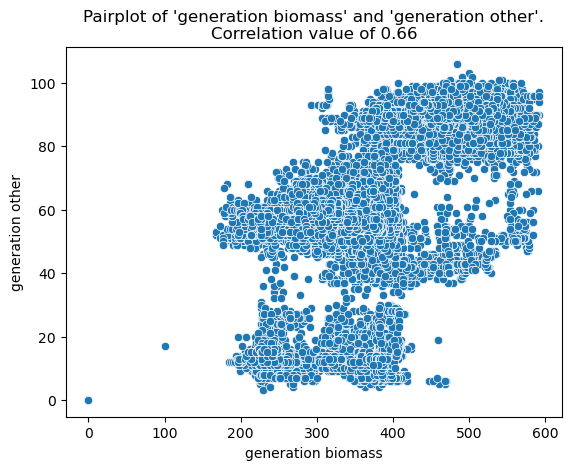

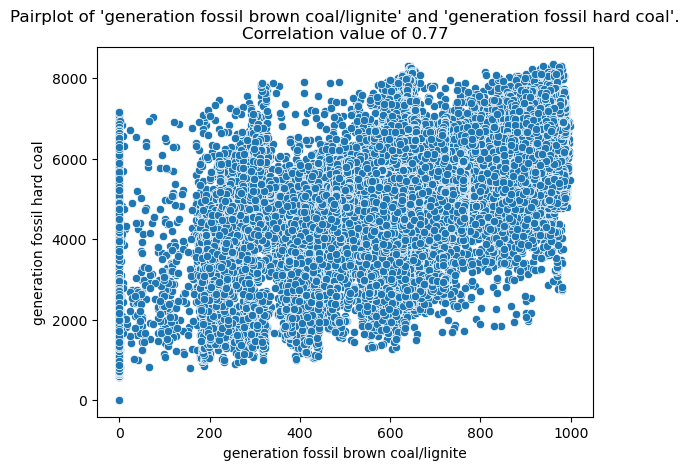

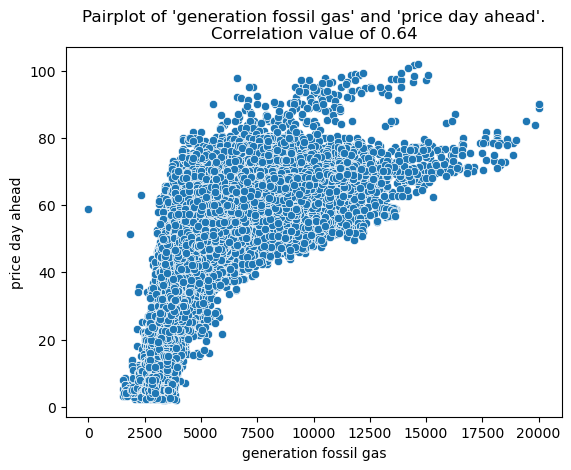

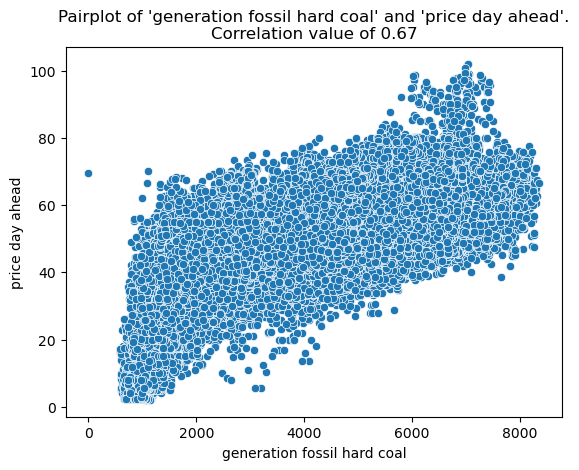

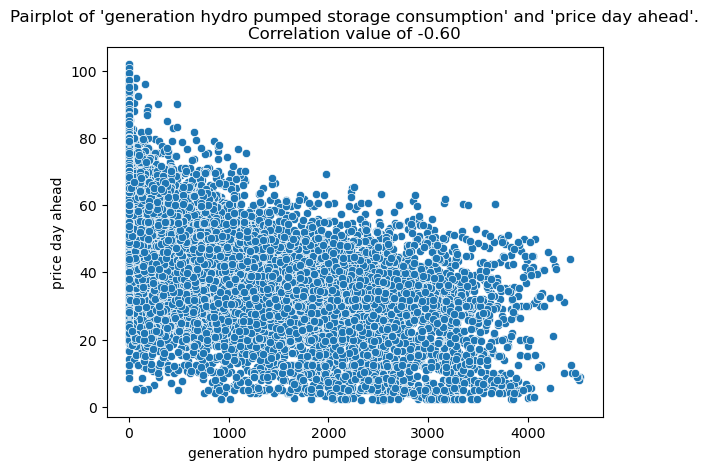

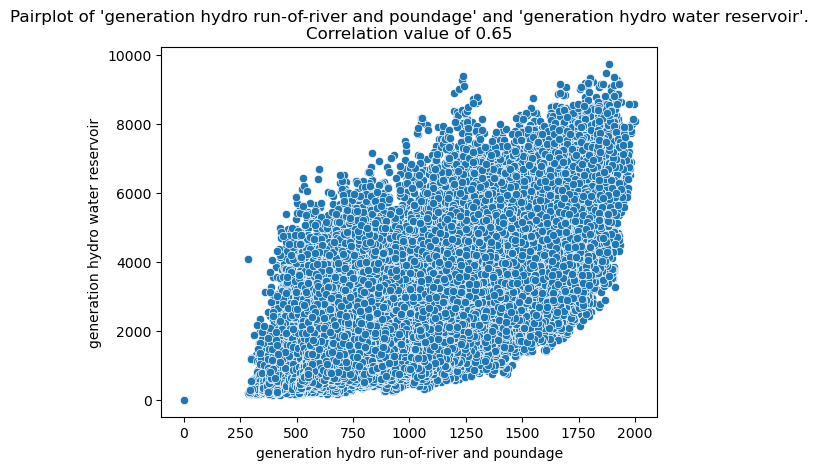

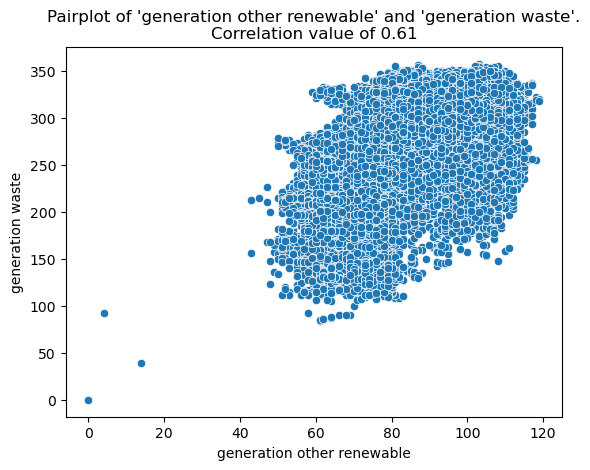

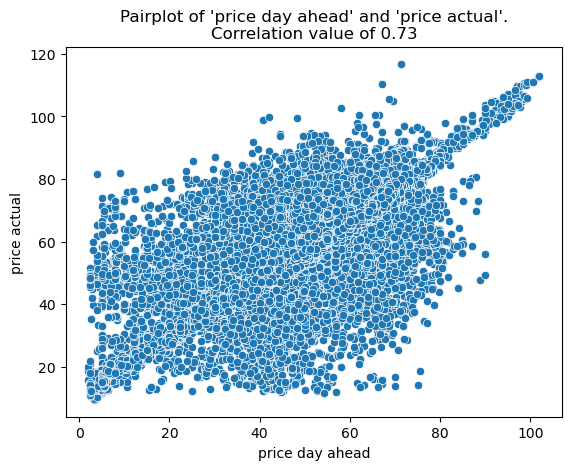

In [52]:
for i, row in correlation_df.iterrows():
    f1, f2, corr_value = row
    if corr_value < -0.6 or corr_value > 0.6:
        sns.scatterplot(data=df_demand_copy, x=f1, y=f2, palette=sns.color_palette('bright'))
        plt.title("Pairplot of \'{}\' and \'{}\'.\nCorrelation value of {:.2f}".format(f1, f2, corr_value))
        print()
        plt.show()

## Target variable histogram

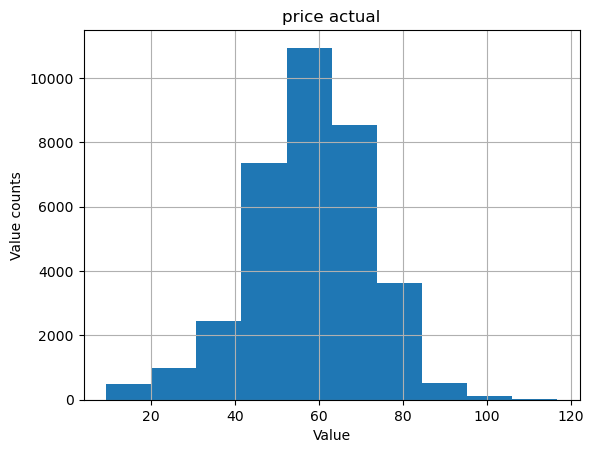

In [53]:
df_demand_copy[target_column].hist()
plt.xlabel('Value')
plt.ylabel('Value counts')
plt.title(target_column)
plt.show()

## Feature variables histogram

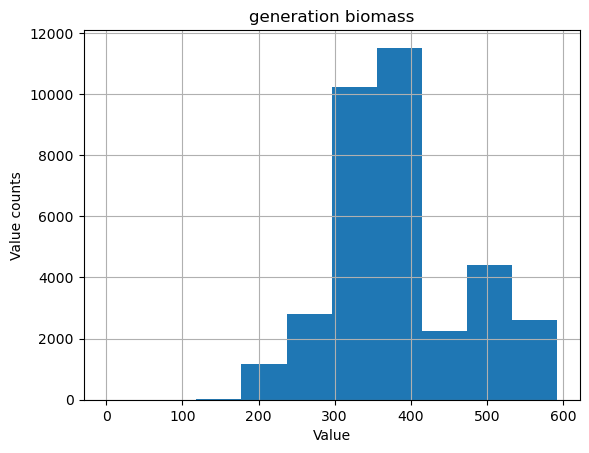

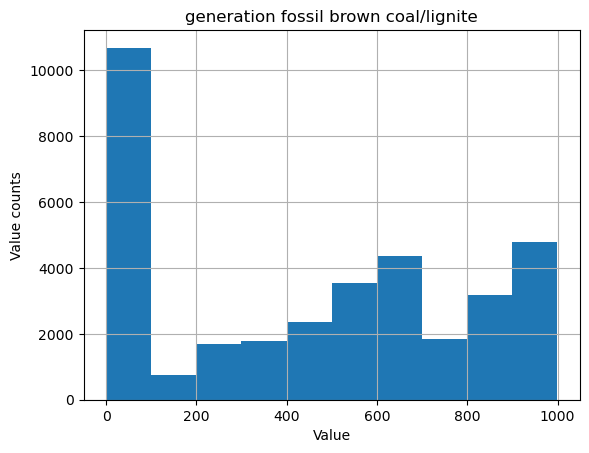

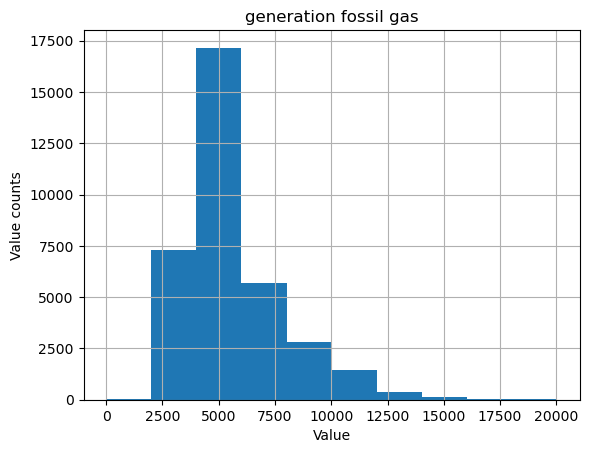

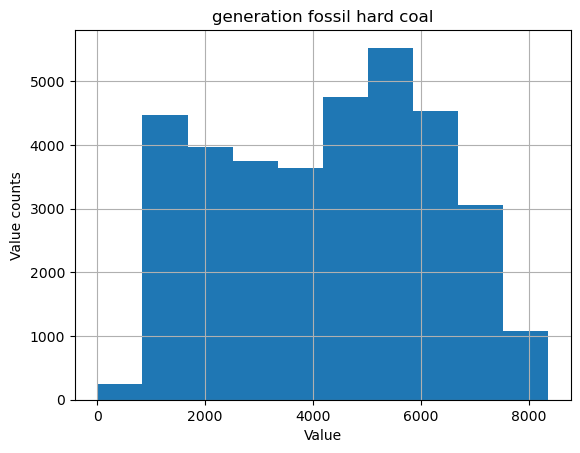

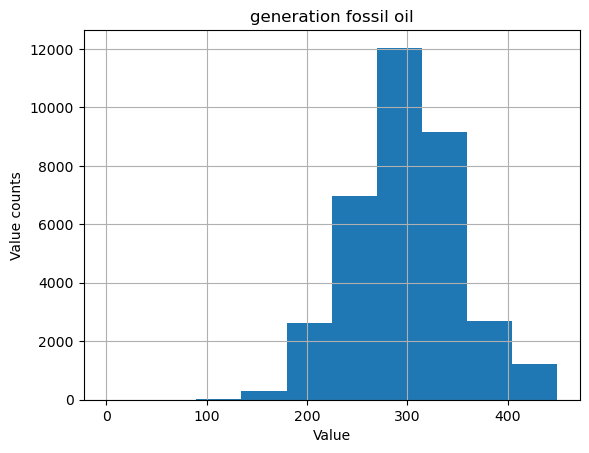

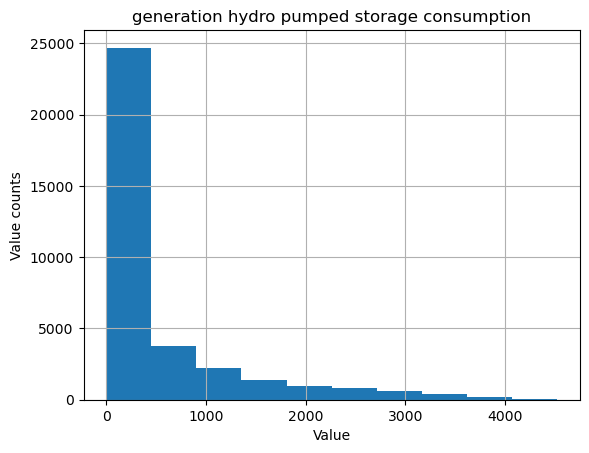

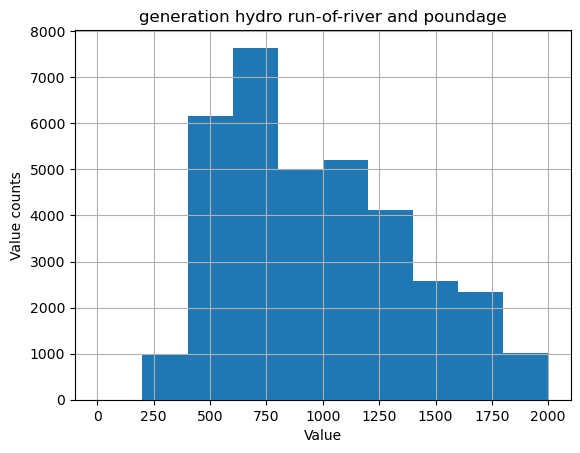

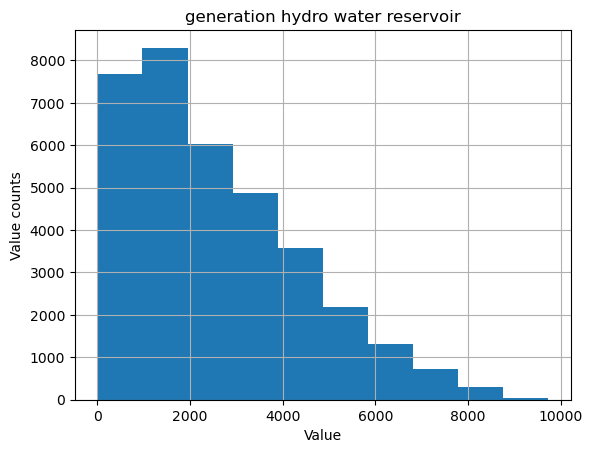

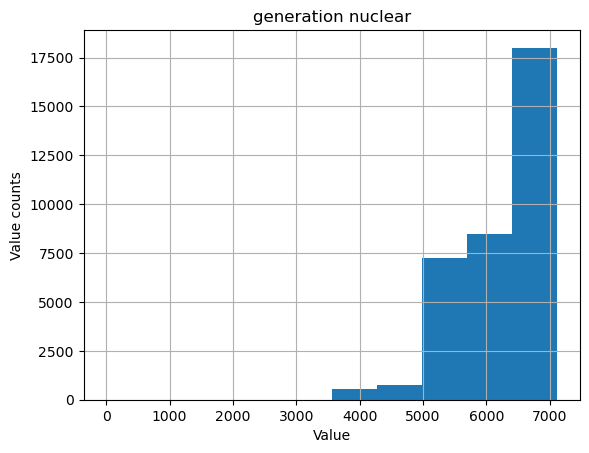

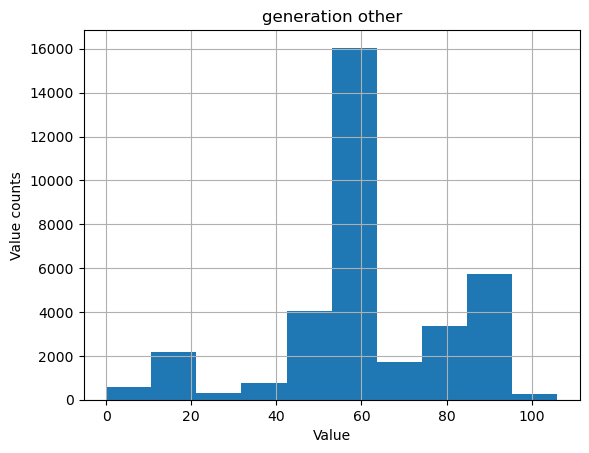

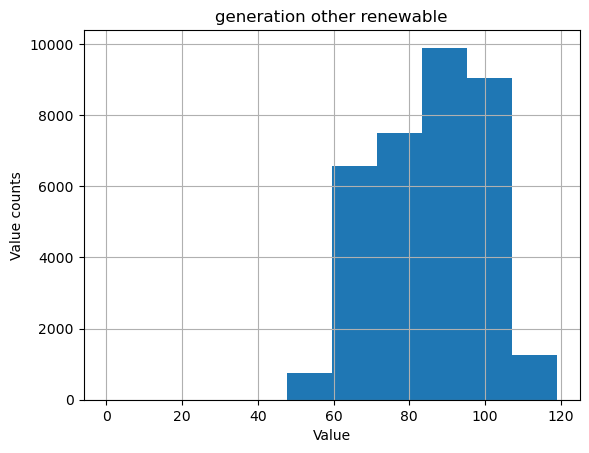

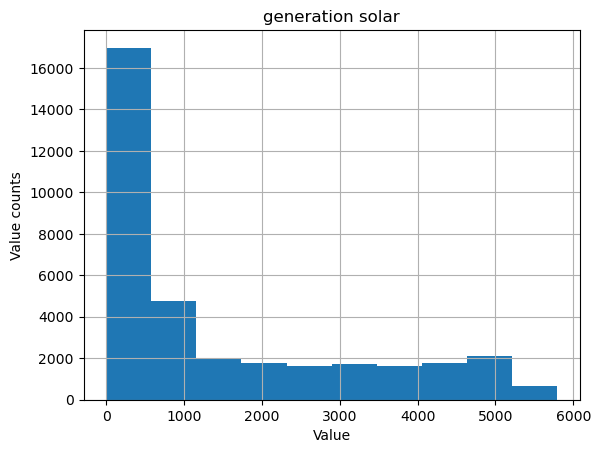

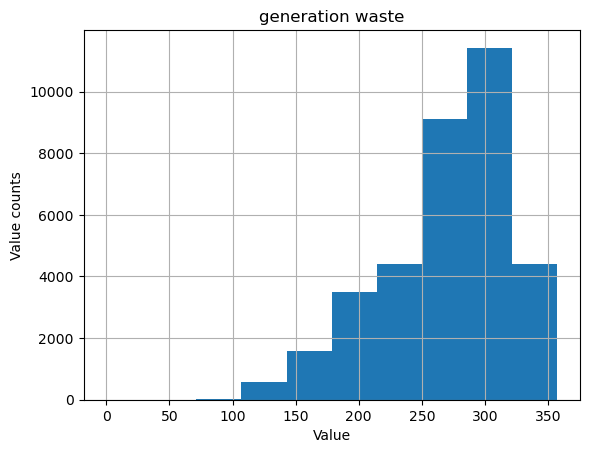

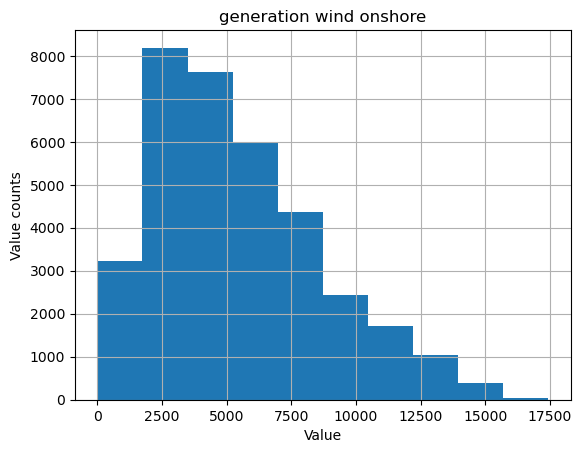

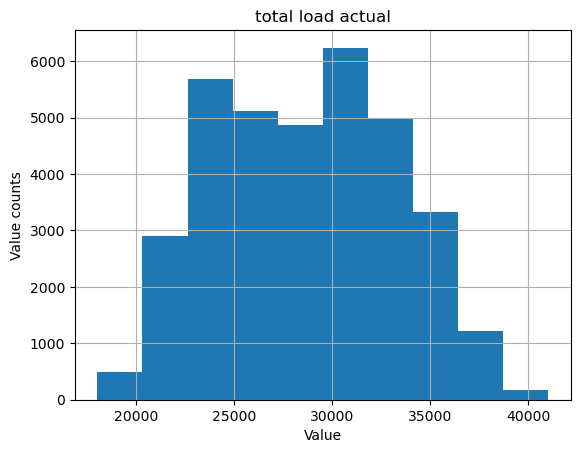

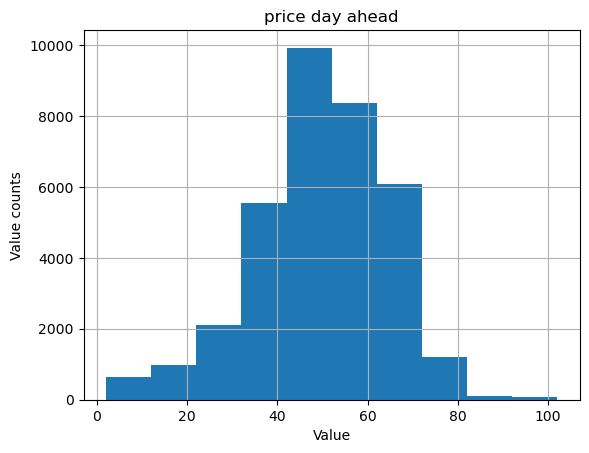

In [54]:
for feature in feature_columns:
    df_demand_copy[feature].hist()
    plt.xlabel('Value')
    plt.ylabel('Value counts')
    plt.title(feature)
    plt.show()
    print()

## Comparison of electricity price and day-ahead electricity price histograms

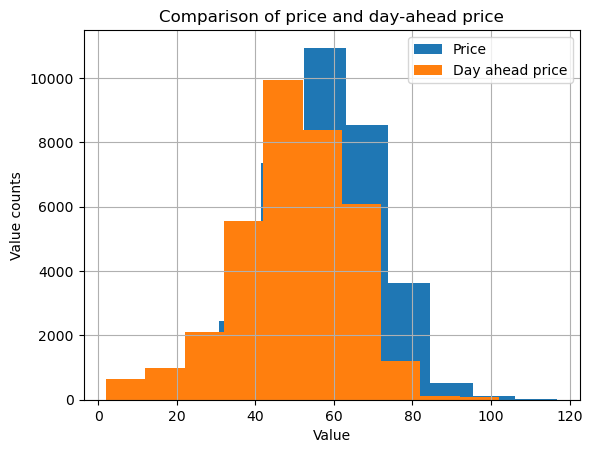

In [55]:
df_demand_copy[target_column].hist(label='Price')
df_demand_copy['price day ahead'].hist(label='Day ahead price')
plt.xlabel('Value')
plt.ylabel('Value counts')
plt.legend()
plt.title('Comparison of price and day-ahead price')
plt.show()

# Dividing our data into training and test set

When working with classical tabular data, we would divide our dataset into training and test sets by separating a random portion (usually between 20 and 30%) for test and using the rest for training.

More information on: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
df_demand_copy = df_demand.copy()
df_demand_copy.dropna(inplace=True, how='any')

# we normally refer to our features as X and to our target as y
y = df_demand_copy.pop(target_column)
X = df_demand_copy.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

However, this is not the usual setup when working with time-series data. Since we are interested in forecasting, it is more realistic to train on several years of data and then try to forecast a whole year as a test.

In [58]:
df_demand_copy = df_demand.copy()
df_demand_copy.dropna(inplace=True, how='any')

# we take data until 2017 for training and from 2017 onwards for testing
X_train = df_demand_copy[:'2017']
y_train = X_train.pop(target_column)

X_test = df_demand_copy['2018':]
y_test = X_test.pop(target_column)

# Establishing a baseline

In [59]:
from sklearn.linear_model import LinearRegression

We can create a simple Linear Regressor and by fitting it to the training set and evaluating its performance on the testing set we just defined, we are setting up a baseline score so later on we can check our model improvement (after feature engineering, handling outliers, normalization techniques, etc).

In [60]:
reg = LinearRegression(fit_intercept=False)
reg.fit(X_train, y_train)

baseline_score = reg.score(X_test, y_test)
baseline_score

0.44860609530245366

In [61]:
def compute_score(df):

    _df = df.copy()

    # divide data between train and test
    X_train = _df[:'2017']
    y_train = X_train.pop(target_column)

    X_test = _df['2018':]
    y_test = X_test.pop(target_column)

    # fit linear regressor to train data and retrieve score on test set
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    
    return model.score(X_test, y_test)

In [62]:
def compute_rel_improvement(old_score, new_score):
    return "There is a relative improvement of {:.2f} %".format(((new_score - old_score) / old_score)*100)

## Adapting k-fold cross validation to time series data

Recall on cross validation: https://scikit-learn.org/stable/modules/cross_validation.html

Cross validation on time-series: https://medium.com/@poudelsushmita878/cross-validation-in-time-series-forecasting-db2bc7601875

In [63]:
def ts_cross_validation(df, year_idxs):
    folds = []
    
    yrs_fold = [year_idxs[0:i] for i in range(2, len(year_idxs)+1)]
    # print(yrs_fold)
    for yrs in yrs_fold:
        train_idx = yrs[:-1]
        train_idx = list(map(str, train_idx))
        
        test_idx = str(yrs[-1])

        # print(train_idx, test_idx)
    
        train_df = df_demand_copy[train_idx[0]:train_idx[-1]]
        test_df = df_demand_copy[test_idx:test_idx]

        folds.append((train_df, test_df))

    return folds
    

In [64]:
def compute_cv_score(df):
    yrs = list(df.index.year.unique())
    folds = ts_cross_validation(df_demand_copy, yrs)

    scores = []
    for X_train, X_test in folds:
        y_train = X_train.pop(target_column)
        y_test = X_test.pop(target_column)
    
        reg = LinearRegression(fit_intercept=False)
        reg.fit(X_train, y_train)
    
        scores.append(reg.score(X_test, y_test))

    return np.mean(scores)

In [65]:
baseline_cv_score = compute_cv_score(df_demand_copy)
baseline_cv_score

0.29113473044394084

# Data scaling and transformation

Transforming and scaling our data can be very useful, specially when our data has outliers or when we are dealing with scale-sensitive algorithms, like distance-based ones or neural networks, for example.

Tutorial on data preprocessing with scikit-learn: https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing

Very interesting notebook on scaling vs. normalization: https://www.kaggle.com/code/alexisbcook/scaling-and-normalization

In [66]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Z-score shifts your data to have a mean of 0 and scales it to have a standard deviation of 1.

In [67]:
df_demand_copy = df_demand.copy()
df_demand_copy.dropna(inplace=True, how='any')

scaler = StandardScaler()
df_demand_copy = pd.DataFrame(scaler.fit_transform(df_demand_copy), index=df_demand_copy.index, columns=df_demand_copy.columns)

new_score = compute_score(df_demand_copy)
new_score

0.45160094582477717

In [68]:
compute_rel_improvement(baseline_score, new_score)

'There is a relative improvement of 0.67 %'

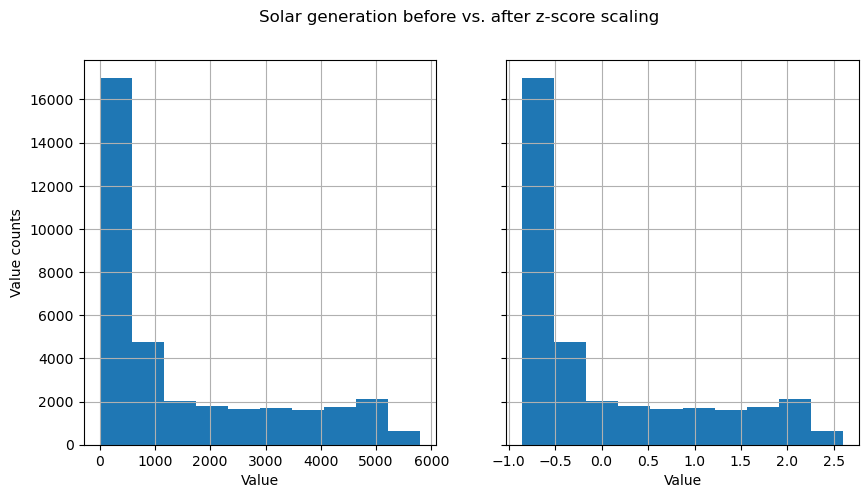

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)

df_demand['generation solar'].hist(ax=ax[0])
df_demand_copy['generation solar'].hist(ax=ax[1])

ax[0].set_xlabel('Value')
ax[1].set_xlabel('Value')
ax[0].set_ylabel('Value counts')

fig.suptitle('Solar generation before vs. after z-score scaling')

plt.show()

We can also scale our features to a given range defined by a minimum and maximum value. Usually we define these as 0 and 1.

In [70]:
df_demand_copy = df_demand.copy()
df_demand_copy.dropna(inplace=True, how='any')

scaler = MinMaxScaler()
df_demand_copy = pd.DataFrame(scaler.fit_transform(df_demand_copy), index=df_demand_copy.index, columns=df_demand_copy.columns)

new_score = compute_score(df_demand_copy)
new_score

0.4497851229708585

In [71]:
compute_rel_improvement(baseline_score, new_score)

'There is a relative improvement of 0.26 %'

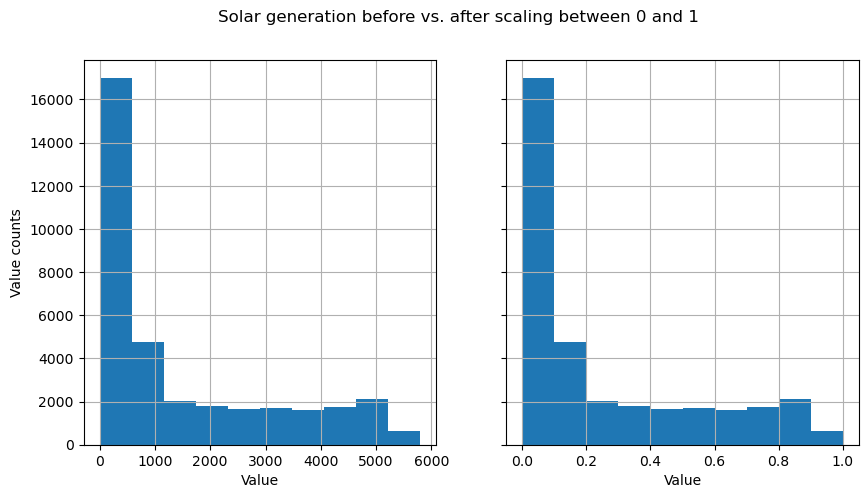

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)

df_demand['generation solar'].hist(ax=ax[0])
df_demand_copy['generation solar'].hist(ax=ax[1])

ax[0].set_xlabel('Value')
ax[1].set_xlabel('Value')
ax[0].set_ylabel('Value counts')

fig.suptitle('Solar generation before vs. after scaling between 0 and 1')

plt.show()

Other interesting transformation methods:
 - Robust scaling
    - to make your data robust to outliers
    - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler
 - Logarithmic transformation
    - https://numpy.org/doc/stable/reference/generated/numpy.log.html
 - Box-cox transformation
    - to make your data more Gaussian-like
    - some ML algorithms rely on the assumption that your data is normally distributed!
    - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer
    - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html#scipy.stats.boxcox


In [73]:
from sklearn.preprocessing import PowerTransformer

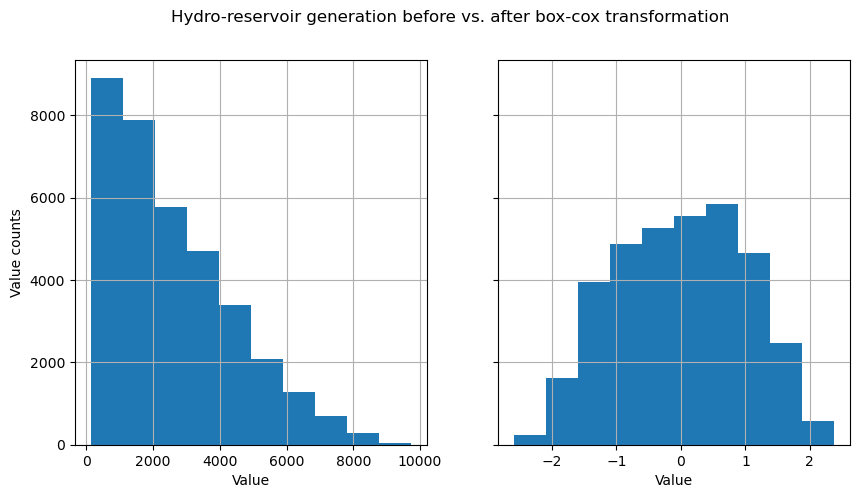

In [74]:
df_demand_copy = df_demand.copy()
df_demand_copy.dropna(inplace=True, how='any')

generation_hydro = df_demand_copy[df_demand_copy['generation hydro water reservoir'] > 0]['generation hydro water reservoir']

scaler = PowerTransformer(method='box-cox')
generation_hydro_transformed = pd.Series(scaler.fit_transform(generation_hydro.values.reshape(-1, 1)).flatten(), index=generation_hydro.index, name='generation hydro water reservoir')

fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)

generation_hydro.hist(ax=ax[0])
generation_hydro_transformed.hist(ax=ax[1])

ax[0].set_xlabel('Value')
ax[1].set_xlabel('Value')
ax[0].set_ylabel('Value counts')

fig.suptitle('Hydro-reservoir generation before vs. after box-cox transformation')

plt.show()

# Handling outliers

Outliers are data points that significantly differ from the majority of the other data points in a dataset. These data points can be unusual in various ways, like having extremely high or low values or being too far away from the mean.

They can hurt our model in several ways:
 - Introduce bias in our model's parameters.
 - Disturb scale-sensitive algorithms.
 - Introduce bias in our model and push it away from generalizing properly.

These are some basic ways of dealing with outliers:
 - Directly removing the outliers from our dataset.
 - Data transformation.
 - Value clipping.

From the previous Visualization step, we saw that some of the features present very left- and righ- skewed distributions. This can be a sign of outliers in our data.

Another quick way of checking this is using the z-score. If a point has a z-score above a certain threshold (e.g., 2 or 3), this means it is considerably far from the mean and thus could be considered an outlier.

In [75]:
df_demand.skew()

generation biomass                             0.421013
generation fossil brown coal/lignite          -0.046831
generation fossil gas                          1.615447
generation fossil hard coal                   -0.073691
generation fossil oil                          0.064469
generation hydro pumped storage consumption    2.130588
generation hydro run-of-river and poundage     0.500928
generation hydro water reservoir               0.897036
generation nuclear                            -0.691683
generation other                              -0.506196
generation other renewable                    -0.216073
generation solar                               1.020388
generation waste                              -0.849129
generation wind onshore                        0.785008
total load actual                              0.061901
price day ahead                               -0.487771
price actual                                  -0.323749
dtype: float64

In [76]:
df_demand_copy = df_demand.copy()
df_demand_copy.dropna(inplace=True, how='any')
scaler = StandardScaler()
df_demand_copy[feature_columns] = scaler.fit_transform(df_demand_copy[feature_columns])

mask = (df_demand_copy[feature_columns] > 4.5) | (df_demand_copy[feature_columns] < -4.5)
mask.any()

generation biomass                             False
generation fossil brown coal/lignite           False
generation fossil gas                           True
generation fossil hard coal                    False
generation fossil oil                           True
generation hydro pumped storage consumption     True
generation hydro run-of-river and poundage     False
generation hydro water reservoir               False
generation nuclear                              True
generation other                               False
generation other renewable                      True
generation solar                               False
generation waste                                True
generation wind onshore                        False
total load actual                              False
price day ahead                                False
dtype: bool

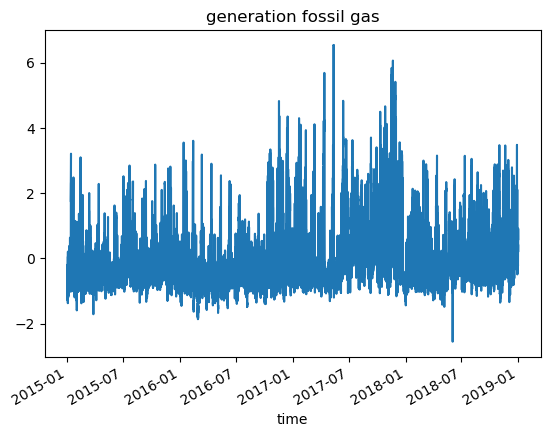

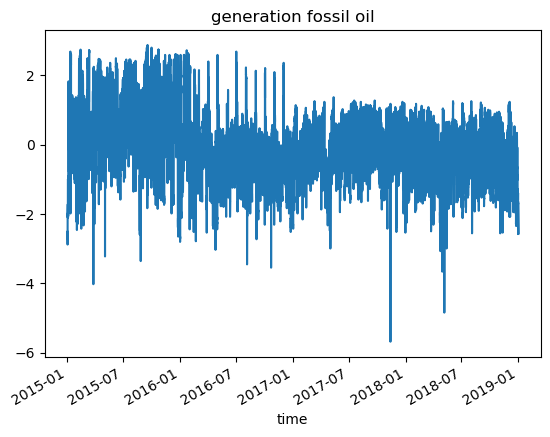

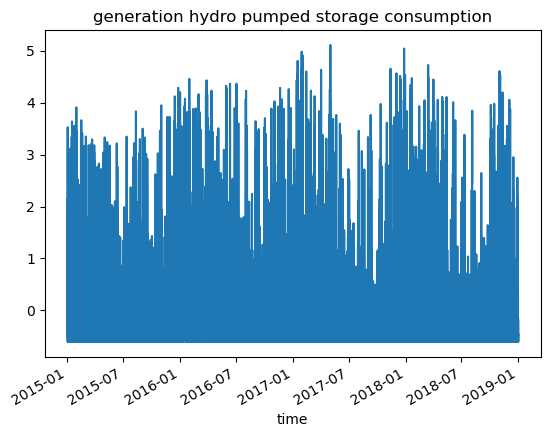

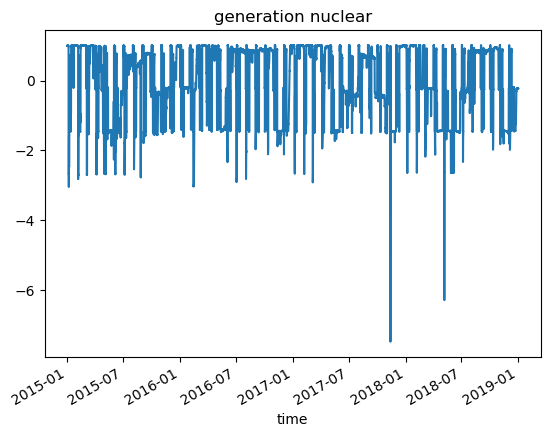

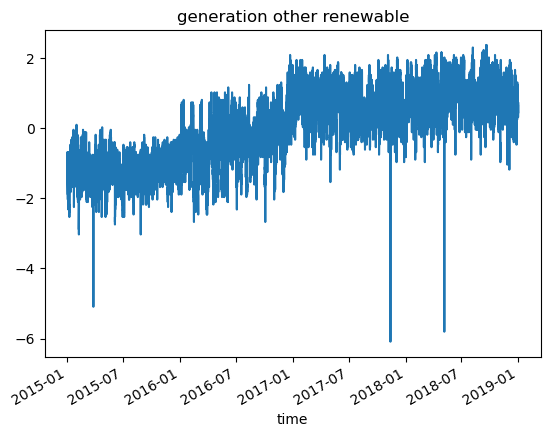

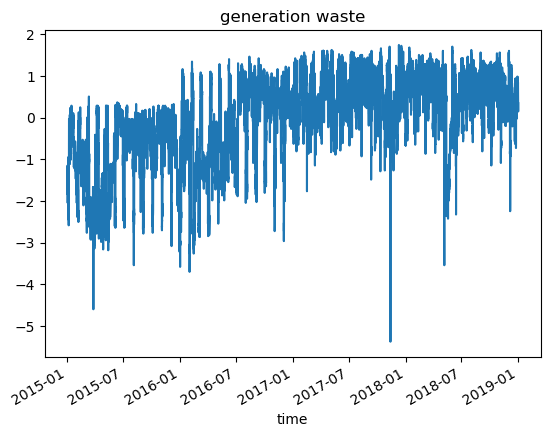

In [77]:
for index, value in mask.any().items():
    if value:
        df_demand_copy[index].plot(title=index)
        plt.show()

In [78]:
df_demand_copy = df_demand.copy()
df_demand_copy.dropna(inplace=True, how='any')

df_demand_copy['generation fossil gas'].clip(2500, 15000, inplace=True)
df_demand_copy['generation fossil oil'].clip(200, 400, inplace=True)
df_demand_copy['generation nuclear'].clip(4000, 7000, inplace=True)
df_demand_copy['generation other renewable'].clip(50, 120, inplace=True)
df_demand_copy['generation waste'].clip(100, 350, inplace=True)

scaler = StandardScaler()
df_demand_copy = pd.DataFrame(scaler.fit_transform(df_demand_copy), index=df_demand_copy.index, columns=df_demand_copy.columns)

new_score = compute_score(df_demand_copy)
new_score

0.4521423686175341

In [79]:
compute_rel_improvement(baseline_score, new_score)

'There is a relative improvement of 0.79 %'

# Feature engineering

## Creating new features

In [120]:
df_demand_copy = df_demand.copy()
df_demand_copy.dropna(inplace=True, how='any')

renewables = ['generation biomass', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind onshore']
non_renewables = ['generation fossil brown coal/lignite', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation nuclear', 'generation other']

df_demand_copy['generation renewables'] = df_demand_copy[renewables].sum(axis=1)
df_demand_copy['generation non-renewables'] = df_demand_copy[non_renewables].sum(axis=1)
df_demand_copy['main generation type'] = df_demand_copy.apply(lambda x: 'renewables' if x['generation renewables'] > x['generation non-renewables'] else 'non-renewables', axis=1)
df_demand_copy['total generation'] = df_demand_copy['generation renewables'] + df_demand_copy['generation non-renewables']

feature_columns_copy = feature_columns.copy()
feature_columns_copy.extend(['generation renewables', 'generation non-renewables'])

### Spin-Off: one-hot encoding of categorical variables

We just introduce a new type of feature: a categorical one. Until now, we had just dealt with numerical features.

In [121]:
df_demand_copy[['price actual', 'generation renewables', 'generation non-renewables', 'main generation type', 'total generation']]

,price actual,generation renewables,generation non-renewables,main generation type,total generation
time,,,,,
2015-01-01 00:00:00+01:00,65.41,10956.0,17295.0,non-renewables,28251.0
2015-01-01 01:00:00+01:00,64.92,10242.0,17576.0,non-renewables,27818.0
2015-01-01 02:00:00+01:00,64.48,9736.0,17060.0,non-renewables,26796.0
2015-01-01 03:00:00+01:00,59.32,9223.0,16000.0,non-renewables,25223.0
2015-01-01 04:00:00+01:00,56.04,9167.0,15453.0,non-renewables,24620.0
...,...,...,...,...,...
2018-12-31 19:00:00+01:00,77.02,9839.0,16576.0,non-renewables,26415.0
2018-12-31 20:00:00+01:00,76.16,9096.0,16117.0,non-renewables,25213.0
2018-12-31 21:00:00+01:00,74.30,8235.0,15752.0,non-renewables,23987.0


In [124]:
df_demand_copy['main generation type'].value_counts()

main generation type
non-renewables    26740
renewables         8278
Name: count, dtype: int64

However, our model cannot interpret the categories per se, but just numbers representing them; so we need to perform an encoding operation!

In [82]:
df_demand_copy = pd.get_dummies(df_demand_copy)

### Measuring new features' impact on model's performance

In [84]:
scaler = StandardScaler()
df_demand_copy = pd.DataFrame(scaler.fit_transform(df_demand_copy), index=df_demand_copy.index, columns=df_demand_copy.columns)

new_score = compute_score(df_demand_copy)
new_score

0.4515175608833004

In [85]:
compute_rel_improvement(baseline_score, new_score)

'There is a relative improvement of 0.65 %'

The intuition behind creating new features would be to try to include in our dataset real-world information that is not present in our dataset originally.

For example, if we had Real Estate (Inmobilien) data and had access to the total size of the property in square meters and the selling price, one straightforward operation for a human would be to create a feature describing the Price per squared meter (€/m²).

Even if for us it can be obvious, our model may not be able to capture that relation, and by adding it explicitly into our data we can improve our model's performance.


## Extracting features

In [86]:
from sklearn.decomposition import PCA

In [87]:
for n_components in range(2, 11):
    df_demand_copy = df_demand.copy()
    df_demand_copy.dropna(inplace=True, how='any')

    pca = PCA(n_components=n_components)
    new_features_names = [f'new_feature_{i}' for i in range(1, n_components+1)]
    df_demand_copy[new_features_names] = pca.fit_transform(df_demand_copy[feature_columns])

    new_score = compute_score(df_demand_copy)

    print("n_components={} ; {}".format(n_components, compute_rel_improvement(baseline_score, new_score)))

n_components=2 ; There is a relative improvement of 0.65 %
n_components=3 ; There is a relative improvement of 0.65 %
n_components=4 ; There is a relative improvement of 0.65 %
n_components=5 ; There is a relative improvement of 0.65 %
n_components=6 ; There is a relative improvement of 0.65 %
n_components=7 ; There is a relative improvement of 0.65 %
n_components=8 ; There is a relative improvement of 0.65 %
n_components=9 ; There is a relative improvement of 0.65 %
n_components=10 ; There is a relative improvement of 0.65 %


In [88]:
from sklearn.cluster import KMeans

In [89]:
for n_clusters in range(2, 16):
    df_demand_copy = df_demand.copy()
    df_demand_copy.dropna(inplace=True, how='any')

    scaler = MinMaxScaler()
    df_demand_copy = pd.DataFrame(scaler.fit_transform(df_demand_copy), index=df_demand_copy.index, columns=df_demand_copy.columns)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df_demand_copy['kmeans_cluster'] = kmeans.fit_predict(df_demand_copy[feature_columns])
    df_demand_copy = pd.get_dummies(df_demand_copy, columns=["kmeans_cluster"])

    new_score = compute_score(df_demand_copy)
    
    print("n_clusters={} ; {}".format(n_clusters, compute_rel_improvement(baseline_score, new_score)))

n_clusters=2 ; There is a relative improvement of 0.63 %
n_clusters=3 ; There is a relative improvement of 0.70 %
n_clusters=4 ; There is a relative improvement of 0.36 %
n_clusters=5 ; There is a relative improvement of 1.20 %
n_clusters=6 ; There is a relative improvement of 1.13 %
n_clusters=7 ; There is a relative improvement of 2.87 %
n_clusters=8 ; There is a relative improvement of 1.42 %
n_clusters=9 ; There is a relative improvement of 0.71 %
n_clusters=10 ; There is a relative improvement of 2.17 %
n_clusters=11 ; There is a relative improvement of 1.51 %
n_clusters=12 ; There is a relative improvement of 1.25 %
n_clusters=13 ; There is a relative improvement of 1.67 %
n_clusters=14 ; There is a relative improvement of 2.02 %
n_clusters=15 ; There is a relative improvement of 2.13 %


## Disaggregating temporal features

In [90]:
df_demand_copy = df_demand.copy()
df_demand_copy.dropna(inplace=True, how='any')

df_demand_copy['quarter'] = df_demand_copy.index.quarter
df_demand_copy['dayofyear'] = df_demand_copy.index.dayofyear
df_demand_copy['dayofweek'] = df_demand_copy.index.dayofweek
df_demand_copy['dayofmonth'] = df_demand_copy.index.day
df_demand_copy['hour'] = df_demand_copy.index.hour
df_demand_copy['month'] = df_demand_copy.index.month

feature_columns_copy = feature_columns.copy()
feature_columns_copy.extend(['quarter', 'dayofyear','dayofweek', 'dayofmonth', 'hour', 'month'])

In [91]:
scaler = StandardScaler()
df_demand_copy = pd.DataFrame(scaler.fit_transform(df_demand_copy), index=df_demand_copy.index, columns=df_demand_copy.columns)

new_score = compute_score(df_demand_copy)
new_score

0.537164476056398

In [92]:
compute_rel_improvement(baseline_score, new_score)

'There is a relative improvement of 19.74 %'

## Lag features

Lagged or features are crucial in time-series forecasting. These features are are created by shifting the original data by one or more time steps (time steps can be minutes, hours, days, etc.)

https://scikit-learn.org/stable/auto_examples/applications/plot_time_series_lagged_features.html

https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py

In [93]:
df_demand_copy = df_demand.copy()
feature_columns_copy = feature_columns.copy()

df_demand_copy.sort_index(inplace=True)
for i in range(1, 4):
    col_name = 'target_' + str(i) + '_days_ago'
    df_demand_copy[col_name] = df_demand_copy[target_column].shift(24*i)
    feature_columns_copy.append(col_name)

df_demand_copy.fillna(0, inplace=True)
# df_demand_copy.dropna(inplace=True, how='any')

scaler = StandardScaler()
df_demand_copy = pd.DataFrame(scaler.fit_transform(df_demand_copy), index=df_demand_copy.index, columns=df_demand_copy.columns)

new_score = compute_score(df_demand_copy)
new_score

0.7416316862389363

In [94]:
# df_demand_copy['2015-01-01':'2015-01-02'][['price actual', 'target_1_days_ago']]

In [95]:
compute_rel_improvement(baseline_score, new_score)

'There is a relative improvement of 65.32 %'

In [96]:
df_demand_copy = df_demand.copy()
feature_columns_copy = feature_columns.copy()

df_demand_copy.sort_index(inplace=True)
for i in range(1, 4):
    col_name = 'demand_' + str(i) + '_days_ago'
    df_demand_copy[col_name] = df_demand_copy['total load actual'].shift(24*i)
    feature_columns_copy.append(col_name)

df_demand_copy.dropna(inplace=True, how='any')

scaler = StandardScaler()
df_demand_copy = pd.DataFrame(scaler.fit_transform(df_demand_copy), index=df_demand_copy.index, columns=df_demand_copy.columns)

new_score = compute_score(df_demand_copy)
new_score

0.4744177412580818

In [97]:
compute_rel_improvement(baseline_score, new_score)

'There is a relative improvement of 5.75 %'

In [98]:
df_demand_copy = df_demand.copy()
feature_columns_copy = feature_columns.copy()

df_demand_copy.sort_index(inplace=True)
for i in range(1, 4):
    col_name = 'day_ahead_price_' + str(i) + '_days_ago'
    df_demand_copy[col_name] = df_demand_copy['price day ahead'].shift(24*i)
    feature_columns_copy.append(col_name)

df_demand_copy.dropna(inplace=True, how='any')

scaler = StandardScaler()
df_demand_copy = pd.DataFrame(scaler.fit_transform(df_demand_copy), index=df_demand_copy.index, columns=df_demand_copy.columns)

new_score = compute_score(df_demand_copy)
new_score

0.5178751741412593

In [99]:
compute_rel_improvement(baseline_score, new_score)

'There is a relative improvement of 15.44 %'

## "Automating" feature engineering

In [100]:
from itertools import combinations

In [101]:
import operator
ops = {'+': operator.add, '-': operator.sub, '*': operator.mul, '/': operator.truediv}

In [102]:
df_demand_copy = df_demand.copy()
df_demand_copy.dropna(inplace=True, how='any')

scaler = StandardScaler()
df_demand_copy = pd.DataFrame(scaler.fit_transform(df_demand_copy), index=df_demand_copy.index, columns=df_demand_copy.columns)

for f1, f2 in list(combinations(feature_columns, 2)):
    for op_symbol, op in ops.items():
        aux = df_demand_copy.copy()
        new_feature_name = f1 + f' {op_symbol} ' + f2
        aux[new_feature_name] = op(aux[f1], aux[f2])

        score = compute_score(aux)
        if score - baseline_score > 0.01:
            print("new feature = {} ; {}".format(new_feature_name, compute_rel_improvement(baseline_score, score)))

new feature = generation biomass * generation hydro pumped storage consumption ; There is a relative improvement of 2.44 %
new feature = generation biomass * generation hydro run-of-river and poundage ; There is a relative improvement of 3.29 %
new feature = generation fossil brown coal/lignite * generation other ; There is a relative improvement of 2.59 %
new feature = generation fossil hard coal * generation other ; There is a relative improvement of 2.67 %


new feature = generation hydro run-of-river and poundage * generation other ; There is a relative improvement of 2.79 %
new feature = generation hydro water reservoir * price day ahead ; There is a relative improvement of 2.40 %


# Wrapping up

Now let us put in practice everything that we have learned until this point and see how all these techniques can improve the performance of our regressor.

In [103]:
df_demand_copy = df_demand.copy()
feature_columns_copy = feature_columns.copy()

# clipping values
df_demand_copy['generation fossil gas'].clip(2500, 15000, inplace=True)
df_demand_copy['generation fossil oil'].clip(200, 400, inplace=True)
df_demand_copy['generation nuclear'].clip(4000, 7000, inplace=True)
df_demand_copy['generation other renewable'].clip(50, 120, inplace=True)
df_demand_copy['generation waste'].clip(100, 350, inplace=True)

# dropping NaN values
df_demand_copy.dropna(inplace=True, how='any')

# scaling data
scaler = StandardScaler()
df_demand_copy[feature_columns] = scaler.fit_transform(df_demand_copy[feature_columns])

y_scaler = StandardScaler()
df_demand_copy[target_column] = y_scaler.fit_transform(df_demand_copy[target_column].values.reshape(-1,1))

# adding kmeans cluster features
kmeans = KMeans(n_clusters=7, random_state=42)
df_demand_copy['kmeans_cluster'] = kmeans.fit_predict(MinMaxScaler().fit_transform(df_demand_copy[feature_columns]))
df_demand_copy = pd.get_dummies(df_demand_copy, columns=["kmeans_cluster"])

# disaggregating temporal information
df_demand_copy['quarter'] = df_demand_copy.index.quarter
df_demand_copy['dayofyear'] = df_demand_copy.index.dayofyear
df_demand_copy['dayofweek'] = df_demand_copy.index.dayofweek
df_demand_copy['dayofmonth'] = df_demand_copy.index.day
df_demand_copy['hour'] = df_demand_copy.index.hour
df_demand_copy['month'] = df_demand_copy.index.month
feature_columns_copy.extend(['quarter', 'dayofyear','dayofweek', 'dayofmonth', 'hour', 'month'])

# more feature engineering
other_features = [
    "generation biomass * generation hydro run-of-river and poundage"
]
df_demand_copy['generation biomass * generation hydro run-of-river and poundage'] = df_demand_copy['generation biomass'] * df_demand_copy['generation hydro run-of-river and poundage']

feature_columns_copy.append(other_features)

# adding lagged features
df_demand_copy.sort_index(inplace=True)
for i in range(1, 4):
    col_name = 'target_' + str(i) + '_days_ago'
    df_demand_copy[col_name] = df_demand_copy[target_column].shift(24*i)
    feature_columns_copy.append(col_name)

    col_name = 'demand_' + str(i) + '_days_ago'
    df_demand_copy[col_name] = df_demand_copy['total load actual'].shift(24*i)
    feature_columns_copy.append(col_name)

    col_name = 'day_ahead_price_' + str(i) + '_days_ago'
    df_demand_copy[col_name] = df_demand_copy['price day ahead'].shift(24*i)
    feature_columns_copy.append(col_name)

# we fill with zeros the NaN values originated from the lagged features
df_demand_copy.fillna(0, inplace=True)

new_score = compute_score(df_demand_copy)
new_score

0.7649591436731604

Let us recall what the baseline score was...

In [104]:
baseline_score

0.44860609530245366

And let us compute the relative improvement between:
 - The baseline score of the linear regressor on the raw data and
 - The score of the linear regressor on the processed data

In [105]:
compute_rel_improvement(baseline_score, new_score)

'There is a relative improvement of 70.52 %'

What about Cross Validation scores ?

In [106]:
baseline_cv_score

0.29113473044394084

In [107]:
new_cv_score = compute_cv_score(df_demand_copy)
new_cv_score

0.7490729612089204

In [108]:
compute_rel_improvement(baseline_cv_score, new_cv_score)

'There is a relative improvement of 157.29 %'

## Visualizing predictions

In [109]:
# divide data between train and test
X_train = df_demand_copy[:'2017']
y_train = X_train.pop(target_column)

X_test = df_demand_copy['2018':]
y_test = X_test.pop(target_column)

# fit linear regressor to train data and retrieve score on test set
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [110]:
y_test.name = 'price'
y_pred = pd.Series(data=y_pred, index=y_test.index, name='price')

In [111]:
y_test = pd.Series(y_scaler.inverse_transform(y_test.values.reshape(-1,1)).flatten(), name='price', index=y_test.index)
y_pred = pd.Series(data=y_scaler.inverse_transform(y_pred.values.reshape(-1,1)).flatten(), index=y_test.index, name='price')

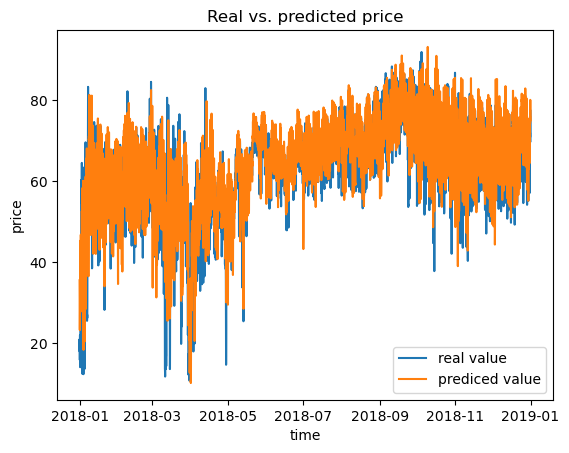

In [112]:
sns.lineplot(y_test, label='real value')
sns.lineplot(y_pred, label='prediced value')

plt.title("Real vs. predicted price")

plt.show()

## Inspiration

What else could you do with this dataset to continue practising? Here are some ideas:
- Try more advanced data imputation methods
- Test data transformations
- Explore other ways of handling outliers
- Introduce and encode categorical features
- Improve feature engineering
- Explore and include the weather features that we have not used at all

## Trying other regression models...

In [113]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

In [114]:
def compute_score(df, model=None, return_fitted_model=False):

    # divide data between train and test
    X_train = df[:'2017']
    y_train = X_train.pop(target_column)

    X_test = df['2018':]
    y_test = X_test.pop(target_column)

    # fit model to train data and retrieve score on test set
    if model is None:
        model = LinearRegression()
    model.fit(X_train, y_train)
    
    if return_fitted_model:
        return model.score(X_test, y_test), model
    else:
        return model.score(X_test, y_test)

0.5407469303760788


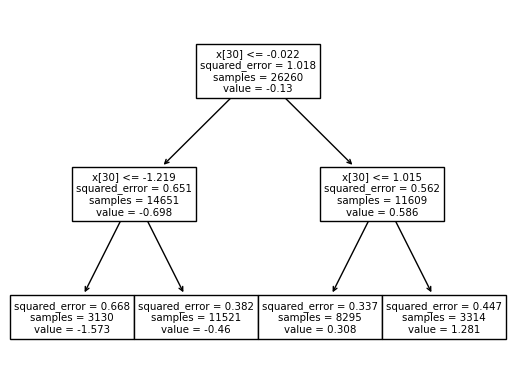

In [115]:
tree = DecisionTreeRegressor(max_depth=2)
score, tree = compute_score(df=df_demand_copy, model=tree, return_fitted_model=True)

print(score)

plot_tree(tree)
plt.show()

In [116]:
tree = DecisionTreeRegressor(max_depth=7)
score, tree = compute_score(df=df_demand_copy, model=tree, return_fitted_model=True)

print(score)

0.7838706417733523


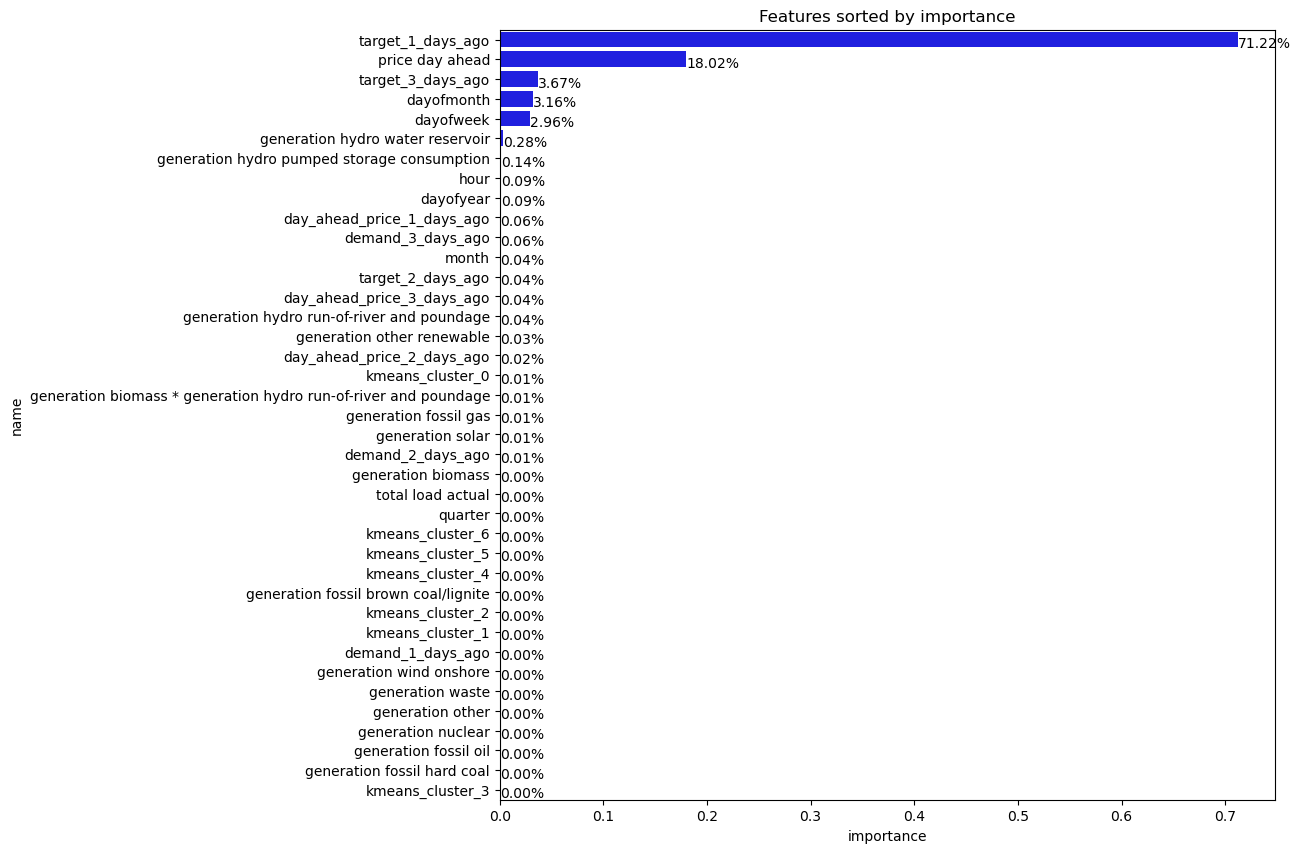

In [117]:
importance_data = pd.DataFrame({'name': tree.feature_names_in_, 'importance': tree.feature_importances_})
importance_data = importance_data.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(data=importance_data,
            x = 'importance',
            y = 'name',
            color='blue'
        )
patches = ax.patches
count = 0
for patch in patches:
    height = patch.get_height() 
    width = patch.get_width()
    perc = 100*importance_data['importance'].iloc[count]
    ax.text(width, patch.get_y() + height, f'{perc:.2f}%')
    count+=1
    
plt.title(f'Features sorted by importance')
plt.show()

In [118]:
## uncomment to try out Random Forest Regressors (may take some time)

# for i in range(2, 8):
#     forest = RandomForestRegressor(max_depth=i)
#     score, forest = compute_score(df=df_demand_copy, model=forest, return_fitted_model=True)
#     print(i, score)